# Jupyter Utilities Demo

MONAI comes with an expanding set of useful utilities for Jupyter notebooks. This demo notebook illustrates their use with a toy segmentation problem. One challenge of Jupyter notebooks is the connection between the browser window and a running cell. Later versions have improved behaviour but there still is a loss of output from running cells if the browser window is closed. Furthermore, while a cell is running no other calls can run, so running code to inspect the training process mid-run isn't possible. 

MONAI's solution is to provide a convenient method for wrapping Ignite `Engine`-derived classes in a thread so that training can happen asynchronously from the notebook's main thread. This allows cells to complete immediately but allow training to continue in the background. Output to stdout/stderr is still (mostly) captured by that cell or whichever cell is subsequently run, but also allows the browser window to be closed or other cells to be run. The wrapper, `ThreadContainer` provides some methods for inspecting the status of the run and plotting some simple outputs. This is particularly useful if you cannot or simply don't want to use external tools like Tensorboard to monitor your progress.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[ignite]"

## Setup imports

In [2]:
import numpy as np
import torch

import monai
from monai.data import Dataset, DataLoader, create_test_image_2d
from monai.losses import DiceLoss
from monai.networks import predict_segmentation
from monai.networks.nets import UNet
from monai.transforms import AddChanneld, Compose, ToTensord
from monai.utils import ThreadContainer
from monai.engines import SupervisedTrainer, SupervisedEvaluator
from monai.utils.enums import CommonKeys
from monai.handlers import MeanDice, ValidationHandler, MetricLogger

monai.config.print_config()

MONAI version: 0.5.0rc4+32.g427331b.dirty
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 427331bd8ca0e786612030e524a56be68347e694

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.1.0
Tensorboard version: 2.4.1
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.56.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Create toy dataset

We'll create a set of image/segmentation pairs with some noise added since the data doesn't really matter for this example.

In [3]:
keys = (CommonKeys.IMAGE, CommonKeys.LABEL)
data = []

for i in range(300):
    rs = np.random.RandomState(i)
    im, seg = create_test_image_2d(256, 256, num_seg_classes=1, noise_max=0.75, random_state=rs)
    data.append({keys[0]: im, keys[1]: seg})

trans = Compose([AddChanneld(keys=keys), ToTensord(keys=keys)])

train_ds = Dataset(data[:240], trans)
val_ds = Dataset(data[240:], trans)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=10, shuffle=True, num_workers=0)

## Create network, loss, optimizer

We'll choose a sub-optimal network configuration here so that training isn't instantaneous:

In [4]:
# Create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
net = UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32),
    strides=(2, 2)
).to(device)

lossfn = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)

## Create trainer and start running in a separate thread

Everything here is standard MONAI code for a simple supervised training run with an evaluator computing a mean dice metric:

In [5]:
max_epochs = 20


def _meandice_transform(x):
    y_pred = x[CommonKeys.PRED]
    y_pred = predict_segmentation(y_pred)
    return y_pred, x[CommonKeys.LABEL]


evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=val_loader,
    network=net,
    key_val_metric={"val_mean_dice": MeanDice(include_background=True, output_transform=_meandice_transform)},
)

logger = MetricLogger(evaluator=evaluator)

train_handlers = [logger, ValidationHandler(1, evaluator)]

trainer = SupervisedTrainer(
    device=device,
    max_epochs=max_epochs,
    network=net,
    optimizer=opt,
    loss_function=lossfn,
    train_data_loader=train_loader,
    train_handlers=train_handlers,
)

The trainer hasn't been started however so the cell above completes immediately. Next we wrap the trainer in a `ThreadContainer` object which inherits from `Thread`. When this thread is started the provided engine (`trainer` in this case) is run within its control flow:

In [5]:
con = ThreadContainer(trainer)
con.start()

This cell also completes immediately with the engine continuing in the background. With this running the browser window can be closed safely after saving the notebook and the run will continue in the background. This may not work as well on platforms like Colab which might timeout notebook sessions, but standard Jupyter servers running on remote machines or containers are compatible.

The status of the engine can be queried as such:

In [6]:
con.status()

'Running, Iters: 17/24, Epochs: 9/20, Loss: 0.07826'

This method and others of `ThreadContainer` are thread-safe in that they will acquire a lock preventing the engine thread from continuing until they complete. This ensures their information is synchronized with the actual status of the engine.

At any time during the run a simple plot can be drawn of the loss over time and metrics, using the `MetricLogger` object as the source of information:

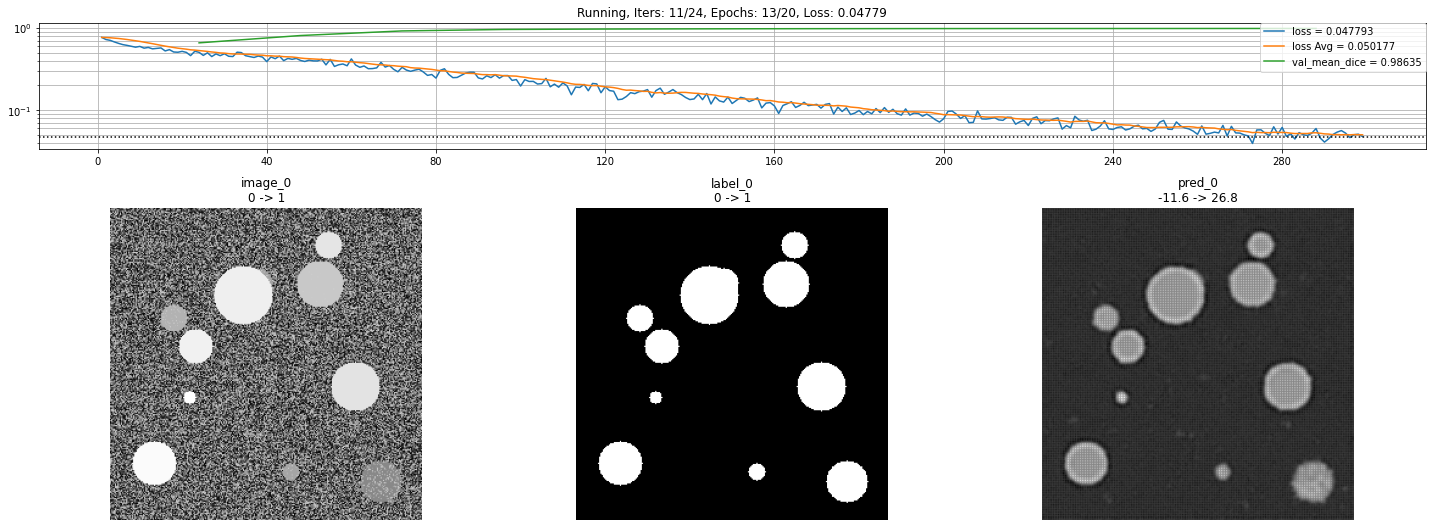

In [7]:
con.plot_status(logger)

The run can be stopped at any time with `stop` which calls `terminate` on the wrapped engine and then joins with the thread:

In [56]:
con.stop()